In [2]:
!pip install --upgrade tdmclient

import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

%matplotlib inline

In [3]:
# Matrix conversion to have dimensions, start and goal positions

def conversion(matrix):

    # Put matrix into numpy array (in case not already)
    arr = np.array(matrix)
    
    # Find the indices of start and goal
    start_arr = np.where(arr == 3)
    goal_arr = np.where(arr == 4)
    
    # Verify there is exactly one 3 and one 4 in the matrix
    if len(start_arr[0]) != 1 or len(goal_arr[0]) != 1:
        print("Error: There should be exactly one start and one goal on the field.")
        return None
    
    # Get the height, width, and positions of start and goal
    max_val_x, max_val_y = arr.shape
    start = (start_arr[0][0], start_arr[1][0])
    goal = (goal_arr[0][0], goal_arr[1][0])

    # Replace the positions of 3 and 4 with 0
    arr[start] = 0
    arr[goal] = 0

    return max_val_x, max_val_y, start, goal, arr

In [4]:
# Grow the obstacles by half the robots radius to avoid collision

def grow_obstacles(matrix, size):
    # Matrix to a numpy array (in case not already)
    arr = np.array(matrix)

    # New matrix with the same shape and filled with zeros
    expanded_matrix = np.zeros_like(arr)

    # Find the indices of obstacles (value = 1) in the original matrix
    obstacle_indices = np.where(arr == 1)

    # Grow obstacles in the expanded matrix
    for i, j in zip(obstacle_indices[0], obstacle_indices[1]):
        # Range for the expanded obstacles
        row_range = slice(max(0, i - size), min(arr.shape[0], i + size + 1))
        col_range = slice(max(0, j - size), min(arr.shape[1], j + size + 1))

        # Setting the corresponding elements to 1 in expanded matrix
        expanded_matrix[row_range, col_range] = 1

    return expanded_matrix

In [5]:
# Helper function for A*

def reconstruct_path(cameFrom, current):
    """
    Recurrently reconstructs the path from start node to the current node
    :param cameFrom: map (dictionary) containing for each node n the node immediately 
                     preceding it on the cheapest path from start to n 
                     currently known.
    :param current: current node (x, y)
    :return: list of nodes from start to current node
    """
    total_path = [current]
    while current in cameFrom.keys():
        # Add where the current node came from to the start of the list
        total_path.insert(0, cameFrom[current]) 
        current=cameFrom[current]
    return total_path

In [19]:
# A* Algorithm, as seen in class

def A_Star(start, goal, h, coords, occupancy_grid, max_val_x, max_val_y):
    """
    A* for 2D occupancy grid. Finds a path from start to goal.
    h is the heuristic function. h(n) estimates the cost to reach goal from node n.
    :param start: start node (x, y)
    :param goal: goal node (x, y)
    :param occupancy_grid: the grid map
    :return: a tuple that contains: (the resulting path in meters, the resulting path in data array indices) -> ???
    """
    
    # Check if the start and goal are within the boundaries of the map
    for point in [start, goal]:
        assert point >= (0, 0) and point[0] < max_val_x and point[1] < max_val_y, "start or end goal not contained in the map"
    
    # check if start and goal nodes correspond to free spaces
    if occupancy_grid[start[0], start[1]]:
        raise Exception('Start node is not traversable')

    if occupancy_grid[goal[0], goal[1]]:
        raise Exception('Goal node is not traversable')
    
    # get the possible movements
    s2 = math.sqrt(2)
    movements = [(1, 0, 1.0), (0, 1, 1.0), (-1, 0, 1.0), (0, -1, 1.0), 
                (1, 1, s2), (-1, 1, s2), (-1, -1, s2), (1, -1, s2)]
    
    # The set of visited nodes that need to be (re-)expanded, i.e. for which the neighbors need to be explored
    # Initially, only the start node is known.
    openSet = [start]
    
    # The set of visited nodes that no longer need to be expanded.
    closedSet = []

    # For node n, cameFrom[n] is the node immediately preceding it on the cheapest path from start to n currently known.
    cameFrom = dict()

    # For node n, gScore[n] is the cost of the cheapest path from start to n currently known.
    gScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    gScore[start] = 0

    # For node n, fScore[n] := gScore[n] + h(n). map with default value of Infinity
    fScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    fScore[start] = h[start]

    # while there are still elements to investigate
    while openSet != []:
        
        #the node in openSet having the lowest fScore[] value
        fScore_openSet = {key:val for (key,val) in fScore.items() if key in openSet}
        current = min(fScore_openSet, key=fScore_openSet.get)
        del fScore_openSet
        
        #If the goal is reached, reconstruct and return the obtained path
        if current == goal:
            return reconstruct_path(cameFrom, current), closedSet

        openSet.remove(current)
        closedSet.append(current)
        
        #for each neighbor of current:
        for dx, dy, deltacost in movements:
            
            neighbor = (current[0]+dx, current[1]+dy)
            
            # if the node is not in the map, skip
            if (neighbor[0] >= occupancy_grid.shape[0]) or (neighbor[1] >= occupancy_grid.shape[1]) or (neighbor[0] < 0) or (neighbor[1] < 0):
                continue
            
            # if the node is occupied or has already been visited, skip
            if (occupancy_grid[neighbor[0], neighbor[1]]) or (neighbor in closedSet): 
                continue
                
            # d(current,neighbor) is the weight of the edge from current to neighbor
            # tentative_gScore is the distance from start to the neighbor through current
            tentative_gScore = gScore[current] + deltacost
            
            if neighbor not in openSet:
                openSet.append(neighbor)
                
            if tentative_gScore < gScore[neighbor]:
                # This path to neighbor is better than any previous one. Record it!
                cameFrom[neighbor] = current
                gScore[neighbor] = tentative_gScore
                fScore[neighbor] = gScore[neighbor] + h[neighbor]

    # Open set is empty but goal was never reached
    print("No path found to goal")
    return [], closedSet

In [20]:
# Calculation of the heuristics: Euclidean distances to goal

def heuristics(max_val_x, max_val_y, goal):
    # List of all coordinates in the grid
    x,y = np.mgrid[0:max_val_x:1, 0:max_val_y:1]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x; pos[:, :, 1] = y
    pos = np.reshape(pos, (x.shape[0]*x.shape[1], 2))
    coords = list([(int(x[0]), int(x[1])) for x in pos])

    # Define the heuristic, here = distance to goal ignoring obstacles (Euclidean)
    h = np.linalg.norm(pos - goal, axis=-1)
    h = dict(zip(coords, h))
    return h, coords

In [21]:
# Calculate the theoretical rotation angle at point B, coming from A, going to C

def calculate_angle(A, B, C):
    vector_AB = np.array(B) - np.array(A)
    vector_BC = np.array(C) - np.array(B)

    dot_product = np.dot(vector_AB, vector_BC)
    magnitude_AB = np.linalg.norm(vector_AB)
    magnitude_BC = np.linalg.norm(vector_BC)

    cos_angle = dot_product / (magnitude_AB * magnitude_BC)
    angle_rad = np.arccos(np.clip(cos_angle, -1.0, 1.0))
    angle_deg = np.degrees(angle_rad)

    return angle_deg

In [497]:
# This function is to select only the keypoint of the path
# param angle_TH: angle threshold
# param max_skip: the max number of left out points between two keypoints

def select_keypoints(path, min_angle, max_skip):
    x_coords, y_coords = path[0], path[1]
    path_length = len(x_coords)
    key_points = [[x_coords[0]], [y_coords[0]]]

    if len(y_coords) != path_length:
        print("Invalid path format.")
        return path
    
    if path_length < 3:
        return path
        
    skip_counter = 0
    
    for i in range(path_length - 2):
        point_A = [x_coords[i], y_coords[i]]
        point_B = [x_coords[i + 1], y_coords[i + 1]]
        point_C = [x_coords[i + 2], y_coords[i + 2]]

        angle_at_point = calculate_angle(point_A, point_B, point_C)
        if(angle_at_point > min_angle or skip_counter == max_skip):
            key_points[0].append(point_B[0])
            key_points[1].append(point_B[1])
            skip_counter = 0
        else: skip_counter = skip_counter + 1
    
    #We add the last point of the path as a Key point          
    key_points[0].append(x_coords[-1])
    key_points[1].append(y_coords[-1])

    return key_points

In [498]:
# Helper function for the display function

def create_empty_plot(max_val_x, max_val_y):
    """
    Helper function to create a figure of the desired dimensions & grid
    
    :param max_val_x and max_val_y: dimension of the map along the x and y dimensions
    :return: the fig and ax objects.
    """
    fig, ax = plt.subplots(figsize=(7,7))
    
    major_ticks_x = np.arange(0, max_val_x+1, 5)
    minor_ticks_x = np.arange(0, max_val_x+1, 1)
    major_ticks_y = np.arange(0, max_val_y+1, 5)
    minor_ticks_y = np.arange(0, max_val_y+1, 1)
    ax.set_xticks(major_ticks_x)
    ax.set_xticks(minor_ticks_x, minor=True)
    ax.set_yticks(major_ticks_y)
    ax.set_yticks(minor_ticks_y, minor=True)
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    ax.set_ylim([-1,max_val_y])
    ax.set_xlim([-1,max_val_x])
    ax.grid(True)
    
    return fig, ax

In [499]:
# Display function

def display(grid, visitedNodes = [], path = [], display_path = False, display_visited = False):
    grid = np.array(grid)
    max_val_x, max_val_y = grid.shape
    start = np.where(grid == 3)
    goal = np.where(grid == 4)
    grid[start] = 0
    grid[goal] = 0
    
    # Select the colors with which to display obstacles and free cells
    cmap = colors.ListedColormap(['white', 'red']) 
    
    # Displaying the map
    fig, ax = create_empty_plot(max_val_x, max_val_y)
    ax.imshow(grid.transpose(), cmap=cmap)
    title = "Occupied cells in red"
    
    # Plot the best path found and the list of visited nodes
    if display_path:
        ax.plot(path[0], path[1], marker="o", color = 'blue');
        title = "Best path in blue"
        
    if display_visited:
        ax.scatter(visitedNodes[0], visitedNodes[1], marker="o", color = 'orange');
        title = title + ", visited nodes in orange"
        
    ax.scatter(start[0], start[1], marker="o", color = 'green', s=200);
    ax.scatter(goal[0], goal[1], marker="o", color = 'purple', s=200);
        
    plt.title(title);

In [500]:
# Overall call with input: matrix and output: simplified path (keypoints), with displaying

def global_keypoints(grid, growth_size = 1, min_angle = 46, max_skip = 3):
    # param growth_size: size of robot radius (in grid dimension) (<-> 5.5cm)
    
    max_val_x, max_val_y, start, goal, obstacle_grid = conversion(grid)

    # Grow the obstacles in the matrix
    grown_grid = grow_obstacles(obstacle_grid, growth_size)

    # Calling A*
    h, coords = heuristics(max_val_x, max_val_y, goal)
    path, visitedNodes = A_Star(start, goal, h, coords, grown_grid, max_val_x, max_val_y)
    path = np.array(path).reshape(-1, 2).transpose()
    visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()
        
    # Select keypoints that have sharp turns (>46deg for example)
    keypoints = select_keypoints(path, min_angle, max_skip)
        
    # Display path
    display(grown_grid, visitedNodes, path, display_path = True, display_visited = True)
    display(grid, visitedNodes, keypoints, display_path = True, display_visited = True)
    
    return path

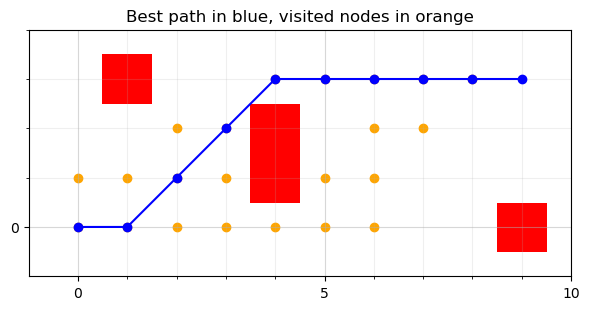

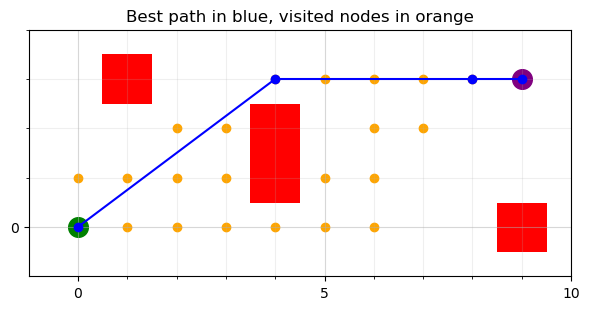

In [509]:
# Example call with handmade example grid

grid = [
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 4],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [3, 0, 0, 0, 0, 0, 0, 0, 0, 1],
]

keypoints = global_keypoints(np.flip(np.array(grid).transpose(), 1),0)

In [510]:
# Function that randomly generates a grid for testing

def grid_generator(max_val_x, max_val_y, obstacle_prob = 97, growth_size = 1):
    # param obstacle_prob: adjust for probability of no obstacle (out of 100)
    
    # Creating the occupancy grid
    data = np.random.rand(max_val_x, max_val_y) * 100 # Create a grid of random values

    # Converting the random values into occupied and free cells
    occupancy_grid = data.copy()
    occupancy_grid[data>obstacle_prob] = 1
    occupancy_grid[data<=obstacle_prob] = 0
    
    grid = np.array(occupancy_grid)
    
    # Pick start and goal so that they are free; for testing purposes only
    # Find the indices of free cells (value = 0)
    free_indices = np.transpose(np.where(grow_obstacles(grid, growth_size) == 0))

    if len(free_indices) < 2:
        print("Error: Not enough space for start and end positions.")

    # Randomly pick two different positions
    np.random.shuffle(free_indices)
    start = tuple(free_indices[0])
    goal = tuple(free_indices[1])
    
    # Put start and goal into the grid
    grid[start] = 3
    grid[goal] = 4
    
    display(grid)
    
    return grid

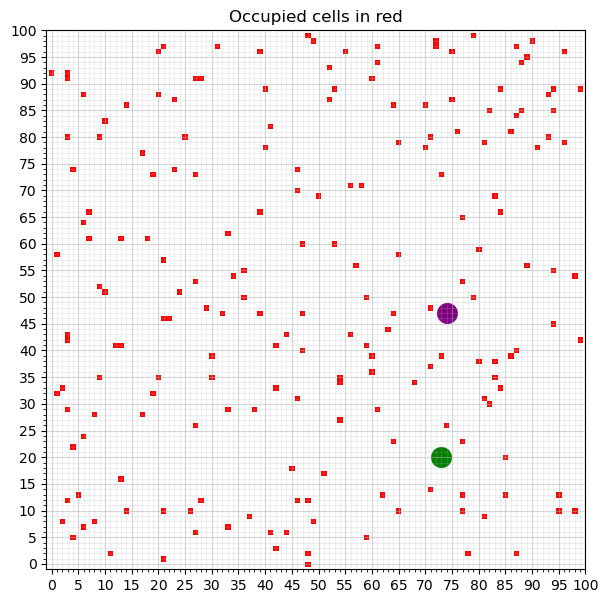

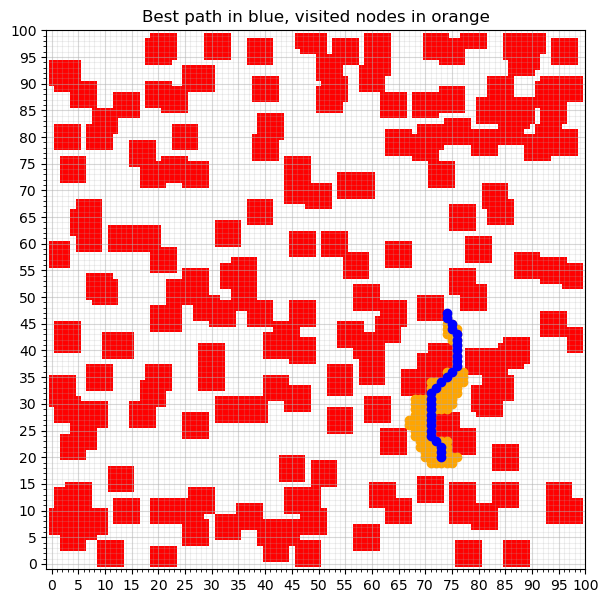

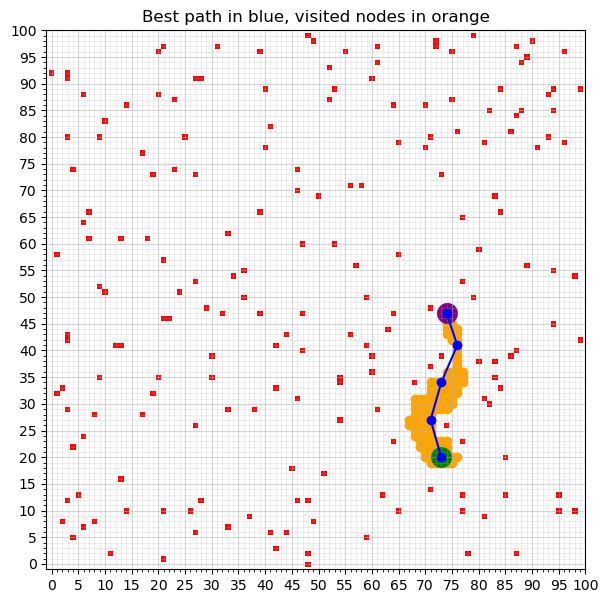

In [516]:
# Generate random example grid, might not be solvable due to randomness: run again (and obstacle_prob >> 0)

grid = grid_generator(100, 100, obstacle_prob = 98, growth_size = 2)
keypoints = global_keypoints(grid, growth_size = 2, max_skip = 6)

In [508]:
# Function that finds nearest keypoint with respect to the robot_position

def find_closest_keypoint_index(robot_position, key_points):
    distances = []

    for i in range(len(key_points[0])):
        distance = np.linalg.norm(np.array(robot_position) - np.array([key_points[0][i], key_points[1][i]]))
        distances.append(distance)
    
    closest_index = np.argmin(distances)
    
    return closest_index

In [517]:
# Function deciding what keypoint to go after, when the robot is off-path

def find_next_closest_keypoint(robot_position, key_points):
    
    # First, find the closest keypoint to be able to exclude it and not go back to it
    closest_index = find_closest_keypoint_index(robot_position, key_points)
    
    # Next, select the next keypoint as a new target, in order to avoid (the local obstacle) getting off path again
    angles = []
    
    for i in range(len(key_points[0])):
        if i == closest_index:
            angles.append(360)  # Ensuring the closest key point isn't considered again
        else:
            closest_keypoint = [key_points[0][i], key_points[1][i]]
            angle = calculate_angle(closest_keypoint, robot_position, [0, 0])
            angles.append(angle)

    next_closest_index = np.argmin(angles)
    
    return next_closest_index

In [525]:
# Test, with robot at position 1,1 and keypoints from the previous Test
find_next_closest_keypoint([1,1], keypoints)

27